# 3D Tomography Experiments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pmcx
from utils import add_ball_to_array, get_arrival_times, get_cw_data, region_to_mua

### medium geometry

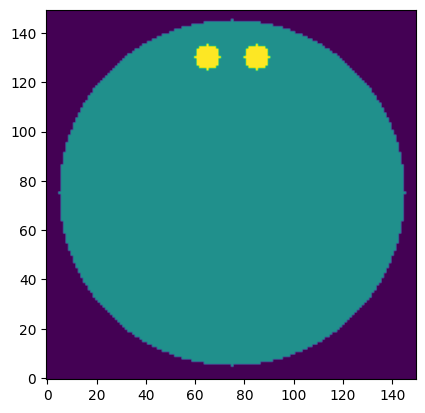

In [3]:
# number of voxels in each dimension
nx = 150
ny = 150
nz = 1 # 2d
r_head = 70 # head radius

# background
region = np.zeros((nz, ny, nx))

# head
region = add_ball_to_array(region, (nz//2, ny // 2, nx//2), r_head, 1)

# add balls
depth = 10 # mm (note this is the depth to the center of the ball)
separation = 10 # mm
r_ball = 5 # ball radius (mm)

region = add_ball_to_array(region, (nz//2, 130, nx//2 - np.floor(separation)), r_ball, 2)
region = add_ball_to_array(region, (nz//2, 130, nx//2 + np.ceil(separation)), r_ball, 2)

plt.imshow(region[nz//2])
plt.gca().invert_yaxis()
plt.show()

### sensor geometry

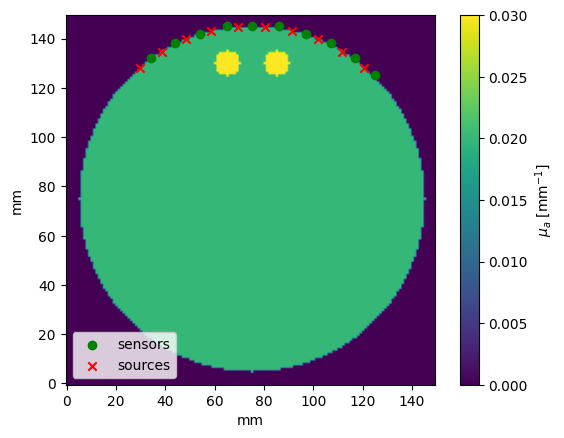

In [35]:
noptodes = 10 # number of optodes (this equates to roughly 1cm spacing)
sensor_positions = np.zeros((noptodes, 2))
source_positions = np.zeros((noptodes, 2))

# Create an array of i values
i_values = np.arange(noptodes)

# Calculate phi for q and m
phi_sensors = i_values / noptodes * np.pi / 2 + np.pi / 4
phi_sources = (i_values + 0.5) / noptodes * np.pi / 2 + np.pi / 4

# Calculate sensor and source positions
center_point = np.array([ny // 2, nx // 2])
sensor_positions  = r_head * np.vstack((np.sin(phi_sensors), np.cos(phi_sensors))).T + center_point
source_positions  = r_head * np.vstack((np.sin(phi_sources), np.cos(phi_sources))).T + center_point
source_directions = center_point - source_positions
source_directions = source_directions / np.linalg.norm(source_directions, axis=1)[:,None] # normalize

# add a column of zeros to cast as 3D
source_positions = np.hstack((nz//2*np.ones((noptodes, 1)), source_positions))
source_directions = np.hstack((np.zeros((noptodes, 1)), source_directions))
sensor_positions = np.hstack((nz//2*np.ones((noptodes, 1)), sensor_positions))
sensor_positions = np.hstack((sensor_positions, np.ones((noptodes, 1))))
sensor_positions = np.ceil(sensor_positions).astype(int)


# info about region
percent_change = 1.5

g = 0.9                    # anisotropy factor
mua0 = 0.02               # background absorption [1/mm]
mus0 = 0.67/(1-g)               # background scattering [1/mm]
mua1 = mua0 * percent_change # absorption of perturbation [1/mm]
mus1 = mus0 * percent_change # scattering of perturbation [1/mm]
refind = 1.4                # refractive index

optical_properties = np.array([
    [0,0,1,1],
    [mua0, mus0, g, refind],
    [mua1, mus1, g, refind]
    ])

mua = region_to_mua(region, optical_properties)

plt.figure()
plt.imshow(mua[nz//2,...])
plt.colorbar(label="$\\mu_a \\text{ }[\\text{mm}^{-1}]$")
plt.scatter(sensor_positions[:,-2], sensor_positions[:,-3], c='g', marker='o', label='sensors')
plt.scatter(source_positions[:,-1], source_positions[:,-2], c='r', marker='x', label='sources')
plt.gca().invert_yaxis()
plt.xlabel("mm"); plt.ylabel("mm")
plt.legend()
plt.show()

In [36]:
def forward(volume, optical_properties, source_positions, source_directions, 
            detector_positions):
    """
    Implements the forward monte carlo solver.
    """

    config = {
        'nphoton': 10000000,
        'vol': volume,
        'tstart': 0,
        'tend': 1e-8,
        'tstep': 1e-8,
        'srcpos': source_positions,
        'srcdir': source_directions,
        'prop': optical_properties,
        'detpos': detector_positions,
        'replaydet':-1,
        'issavedet': 1,
        'issrcfrom0': 1,
        'issaveseed': 1,
        # 'unitinmm': 1.8,
        # 'maxdetphoton': 1000000000
    }

    result = pmcx.mcxlab(config)
    return result, config

def compute_jacobian(forward_result, config):
    
    config['seed']       = forward_result['seeds']  # one must define config['seed'] using the returned seeds
    config['detphotons'] = forward_result['detp']['data']   # one must define config['detphotons'] using the returned detp data
    config['outputtype'] = 'jacobian'               # tell mcx to output absorption (μ_a) Jacobian

    result = pmcx.run(config)
    return result, config

In [37]:
source_index = 4

res_true, cfg_true = forward(region, optical_properties, source_positions[source_index], source_directions[source_index], sensor_positions)

nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
issrcfrom0: 1
replaydet: -1
srcpos: [0, 144.784, 80.4921, 1]
srcdir: [0, -0.996917, -0.0784591, 0]
issavedet: 1
issaveseed: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse,#
#  Please consider using JSON (https://n

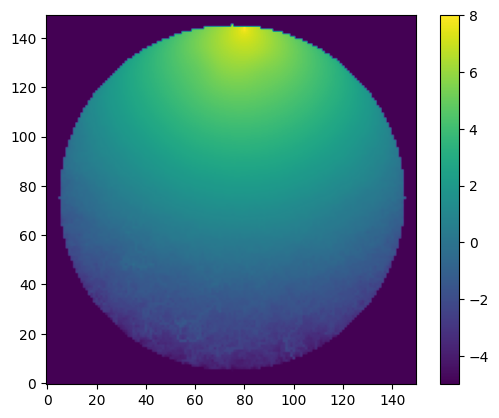

In [38]:
plt.imshow((np.log10(res_true['flux'][nz//2, :, :, 0]+1e-5)))
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [39]:
optical_properties_bg = np.array([
    [0,0,1,1],
    [mua0, mus0, g, refind],
    [mua0, mus0, g, refind] # set perturbation to background
    ])
res_bg, cfg_bg = forward(region, optical_properties_bg, source_positions[source_index], source_directions[source_index], sensor_positions)

nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
issrcfrom0: 1
replaydet: -1
srcpos: [0, 144.784, 80.4921, 1]
srcdir: [0, -0.996917, -0.0784591, 0]
issavedet: 1
issaveseed: 1
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and

In [40]:
res_jac, cfg_jac = compute_jacobian(res_bg, cfg_bg)

nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
issrcfrom0: 1
replaydet: -1
srcpos: [0, 144.784, 80.4921, 1]
srcdir: [0, -0.996917, -0.0784591, 0]
issavedet: 1


issaveseed: 1
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse,#
#  Please consider using J

In [42]:
cfg_true['detpos'][:,:3]

array([[  0., 125., 125.],
       [  0., 132., 117.],
       [  0., 138., 107.],
       [  0., 142.,  97.],
       [  0., 145.,  86.],
       [  0., 145.,  75.],
       [  0., 145.,  65.],
       [  0., 142.,  54.],
       [  0., 138.,  44.],
       [  0., 132.,  34.]])

In [32]:
# arrival_times_by_detector = get_arrival_times(res['detp'], optical_properties)

data = get_cw_data(res_true, cfg_true)
data_bg = get_cw_data(res_bg, cfg_bg)
J = res_jac['flux'] # Jacobian of shape (nz, ny, nx, nt, ndetectors)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

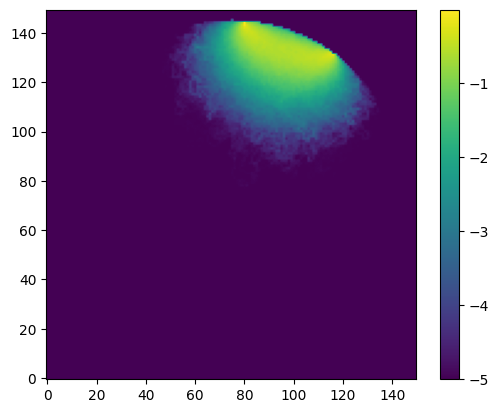

In [20]:
plt.imshow((np.log10(res_jac['flux'][nz//2, :, :, 0,1]+1e-5)))
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [21]:
# compare pertubation from Jacobian to the true pertubation
dmua = region_to_mua(region, optical_properties) - region_to_mua(region, optical_properties_bg)
dmua_reshaped = dmua[..., np.newaxis, np.newaxis]
dintensity = np.tensordot(J, dmua_reshaped, axes=([0,1,2], [0,1,2]))
dintensity = dintensity.squeeze()

In [22]:
res_true['flux'].shape

(1, 150, 150, 1)

/tmp/ipykernel_139341/4128485145.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(data_bg), label='background')
/tmp/ipykernel_139341/4128485145.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(data), label='with perturbation')


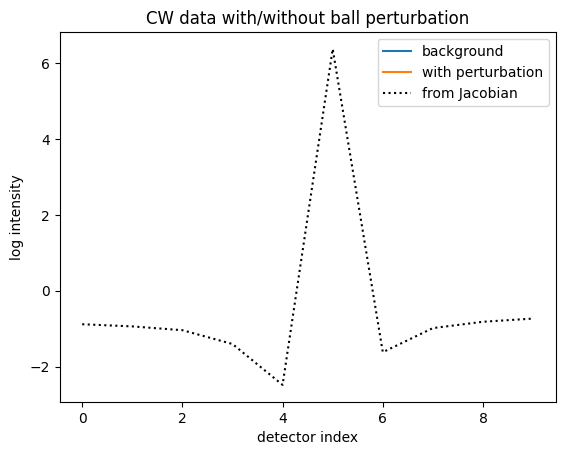

In [23]:
# plot with opacity
plt.plot(np.log10(data_bg), label='background')
plt.plot(np.log10(data), label='with perturbation')
plt.plot(np.log10(data_bg + dintensity), label='from Jacobian', linestyle=':', color='k')

# plt.plot(data_bg, label='background')
# plt.plot(data, label='with perturbation')
# plt.plot(data_bg + dintensity, label='from Jacobian', linestyle=':', color='k')

plt.xlabel("detector index")
plt.ylabel("log intensity")
plt.legend()
plt.title("CW data with/without ball perturbation")
plt.show()

## Junk

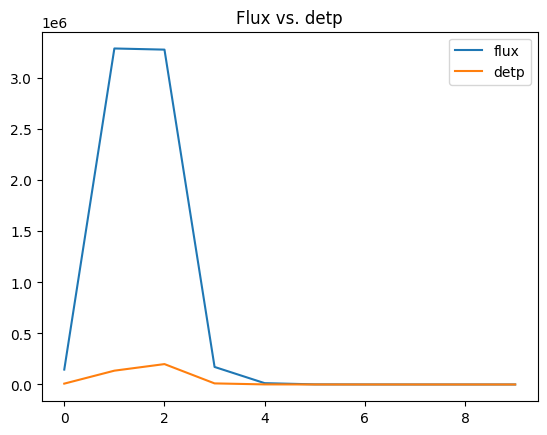

In [154]:
# res2['flux']
# sensor_positions[:,1:3]
flux = res['flux'].squeeze()
sensor_positions[:,1:3]

# grab flux at sensor positions
flux_at_sensors = flux[sensor_positions[:,1].astype(int), sensor_positions[:,2].astype(int)]

data_vals = np.array(list(data.values()))
plt.plot(flux_at_sensors, label='flux')
plt.plot(data_vals, label='detp')
plt.legend()
plt.title("Flux vs. detp")
plt.show()

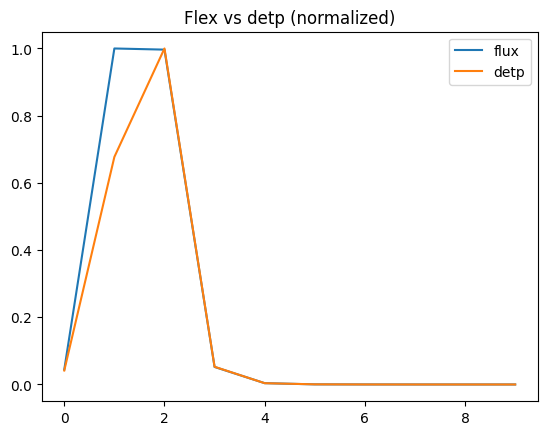

In [155]:
# plot normalized

plt.plot(flux_at_sensors / np.max(flux_at_sensors), label='flux')
plt.plot(data_vals / np.max(data_vals), label='detp')
plt.legend()
plt.title("Flex vs detp (normalized)")
plt.show()

In [ ]:
pmcx.gpuinfo()

In [29]:
# prop: (µa, µs, g, n)

prop = np.array([
    [0,0,1,1], # air
    [0.0200,  9.0000,  0.8900,  1.3700]]) # gray matter
cfg = {
       'nphoton': 1000000,
       'vol':np.ones([1,60,60],dtype='uint8'),
       'tstart':0,
       'tend':5e-9,
       'tstep':5e-9,
       'srcpos': [0,30,0],
       'srcdir':[0,0,1],
       'prop': prop,
       # 'detpos': [[0,30,30, 2],[0,30,30,2], [0,30,0,2]],
       'issavedet': 0,
       'issrcfrom0': 1
       }
res = pmcx.mcxlab(cfg)


nphoton: 1e+06
tstart: 0
tstep: 5e-09
tend: 5e-09
issrcfrom0: 1
srcpos: [0, 30, 0, 1]
srcdir: [0, 0, 1, 0]
issavedet: 0
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #


In [18]:
res['flux'].shape

(1, 60, 60, 1)

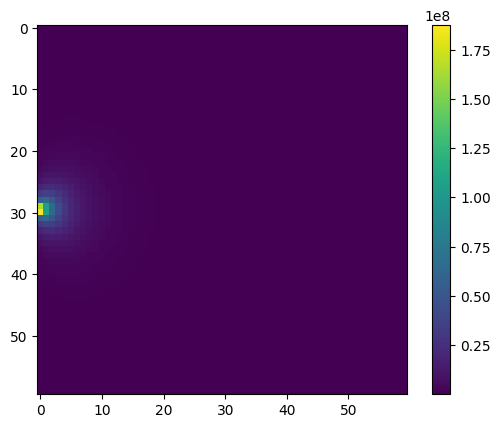

In [30]:
plt.imshow((res['flux'][0,:, :]))
plt.colorbar()
plt.show()

In [16]:
plt.hist(res['detp']['ppath'][:,0], bins=100, range=[0,200]);

KeyError: 'detp'

In [ ]:
from pmcx import dettime
arrival_times = dettime(res['detp'], prop=prop)

In [89]:
arrival_times.shape

(1, 48155)

In [ ]:
plt.hist(arrival_times[0,:], bins=100, range=[0, 0.5e-9])
plt.show()

In [ ]:
import jdata as jd

In [ ]:
shape=[]
shape.append({'Grid':{'Tag':1, 'Size':[40,60,30]}})
shape.append({'Sphere':{'Tag':2, 'O':[20,30,10], 'R':10}})

cfg['shapes']=jd.show({'Shapes':shape}, {'string':True})

In [ ]:
hist, bins = np.histogram(res['detp']['data'][0])
print("Histogram values:", hist)
print("Bins:", bins)

In [ ]:
res['detp']['detid'].shape

In [ ]:
res['detp']['data'].shape

In [ ]:
np.sum(res['detp']['data'][0] - res['detp']['detid'])

In [ ]:
plt.imshow(np.log10(res['flux'][30,:, :]))
plt.show()

In [ ]:
plt.imshow(np.log10(res['flux'][30,:, :]))
plt.show()